# XGBoost

## Load data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from collections import defaultdict
import datetime
import pickle
import math
import os
from xgboost import plot_importance
from scipy.stats import skew, norm
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

pd.set_option('display.max_columns', None) # no truncate columns

In [2]:
# Environment settings
data_path_out = 'Data/output/'
    
# Deserialize previously saved data from "data-visualization"
with open(data_path_out + 'train_pp.obj', 'rb') as file:
    all_train = pickle.load(file)
with open(data_path_out + 'test_pp.obj', 'rb') as file:
    all_test = pickle.load(file)
    
all_train_orig = all_train.copy()

## Preprocessing

### Drop now useless variables

In [3]:
all_train = all_train.drop(labels=['Region', 'Date'], axis=1)
print(all_train.shape)
all_train.head()

(523021, 70)


,StoreID,IsHoliday,IsOpen,HasPromotions,NearestCompetitor,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,Max_Dew_PointC,Max_Humidity,Max_Sea_Level_PressurehPa,Max_TemperatureC,Max_VisibilityKm,Max_Wind_SpeedKm_h,Mean_Dew_PointC,Mean_Humidity,Mean_Sea_Level_PressurehPa,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees,Events_Hail,Hol_and_open,Region_PD,week_of_month,year,quarter,month,day_of_month,day_of_week,day_of_year,WeekOfYear,days_in_month,Region_0,Region_1,Region_10,Region_2,Region_3,Region_4,Region_5,Region_7,Region_9,Region_6,Region_8,AssortmentType_General,AssortmentType_With Non-Food Department,AssortmentType_With Fish Department,StoreType_Hyper Market,StoreType_Standard Market,StoreType_Super Market,StoreType_Shopping Center,Events_Fog,Events_Rain,Events_Snow,Events_Thunderstorm,Events_Normal,HolidaysWeekBefore,HolidaysWeekCurrent,HolidaysWeekAfter,PromoWeekBefore,PromoWeekCurrent,PromoWeekAfter,NumberOfSales
0,1000,False,True,False,326,9643,17130,2770,8.0,1,100,1032,2,19.0,21,-1,82,1030,1,11.0,16,-2,70,1029,1,6.0,0.0,23,False,False,0.287255,0,2016,1,3,1,1,61,9,31,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5676
1,1000,False,True,False,326,9643,17130,2770,8.0,0,87,1030,5,23.0,16,-1,73,1027,3,13.0,10,-2,58,1025,1,10.0,0.0,56,False,False,0.287255,0,2016,1,3,2,2,62,9,31,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,5,8111
2,1000,False,True,False,326,9643,17130,2770,8.0,0,81,1026,4,31.0,23,-1,71,1024,3,11.0,10,-3,55,1023,2,8.0,0.0,22,False,False,0.287255,0,2016,1,3,4,4,64,9,31,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,5,8300
3,1000,False,True,False,326,9643,17130,2770,6.0,-3,80,1027,8,31.0,19,-4,56,1024,3,15.0,10,-6,25,1022,-1,10.0,0.0,108,False,False,0.287255,0,2016,1,3,5,5,65,9,31,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,5,7154
4,1000,False,False,False,326,9643,17130,2770,6.0,0,93,1025,7,31.0,16,-3,75,1023,1,12.0,5,-6,48,1022,-5,5.0,0.0,46,False,False,0.287255,0,2016,1,3,6,6,66,9,31,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,5,0


In [4]:
filter_startswith = lambda l,s: [x for x in l if x.startswith(s)]

# regional features
r_regions = ['Region_'+str(i) for i in range(11)]
r_assortments = filter_startswith(all_train.columns, 'AssortmentType_')
r_storetype = filter_startswith(all_train.columns, 'StoreType_')
r_general = ['NearestCompetitor', 'Region_AreaKM2', 'Region_GDP', 'Region_PopulationK', 'Region_PD']
regional_features =  r_regions + r_assortments + r_storetype + r_general

# meteo features
m_events = filter_startswith(all_train.columns, 'Events_')
m_general = ['CloudCover', 'Max_Dew_PointC', 'Max_Humidity', 'Max_Sea_Level_PressurehPa',
             'Max_TemperatureC', 'Max_VisibilityKm', 'Max_Wind_SpeedKm_h',
             'Mean_Dew_PointC', 'Mean_Humidity', 'Mean_Sea_Level_PressurehPa',
             'Mean_TemperatureC', 'Mean_VisibilityKm', 'Mean_Wind_SpeedKm_h',
             'Min_Dew_PointC', 'Min_Humidity', 'Min_Sea_Level_PressurehPa',
             'Min_TemperatureC', 'Min_VisibilitykM', 'Precipitationmm',
             'WindDirDegrees']
meteo_features =  m_events + m_general

# store features
store_features = ['IsHoliday', 'IsOpen', 'HasPromotions', 'Hol_and_open']

# seasonal features
seasonal_features = ['week_of_month', 'year', 'quarter', 'month', 'day_of_month',
                     'day_of_week', 'day_of_year', 'WeekOfYear', 'days_in_month',
                     'HolidaysWeekBefore', 'HolidaysWeekCurrent', 'HolidaysWeekAfter',
                     'PromoWeekBefore', 'PromoWeekCurrent', 'PromoWeekAfter']

# x and y specific
x_features = ['StoreID']
y_features = ['NumberOfSales']

In [5]:
# Robust Scaler
rs = RobustScaler()

scale_features_list = r_general + m_general

all_train[scale_features_list] = rs.fit_transform(all_train[scale_features_list])
all_test[scale_features_list] = rs.fit_transform(all_test[scale_features_list])

## Train and predict

In [6]:
# drop useless features
all_train = all_train.drop(labels=m_general, axis=1)
all_test = all_test.drop(labels=m_general, axis=1)

In [7]:
y_train = all_train.NumberOfSales
x_train = all_train.drop('NumberOfSales', axis=1)

model = XGBRegressor(silent=False, n_jobs=4, max_depth=9, learning_rate=0.2)
kfold = KFold(n_splits=5, shuffle=True, random_state=7)
results = cross_val_score(model, x_train, y_train, scoring='r2', cv=kfold, verbose=2)

[CV]  ................................................................
[CV] ................................................. , total= 1.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ................................................. , total= 1.2min
[CV]  ................................................................
[CV] ................................................. , total= 1.2min
[CV]  ................................................................
[CV] ................................................. , total= 1.1min
[CV]  ................................................................
[CV] ................................................. , total= 1.1min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.7min finished


In [8]:
print('Cross-validation score: {:.4f} with +/- {:.4f}'\
      .format(results.mean(),results.std()))
# 0.9569 with +/- 0.0008

Cross-validation score: 0.9569 with +/- 0.0008


In [5]:
# params = {
#     # Parameters that we are going to tune.
#     'max_depth':6,
#     'min_child_weight': 1,
#     'eta':.3,
#     'subsample': 1,
#     'colsample_bytree': 1,
#     # Other parameters
#     'objective':'reg:linear',
# }

In [6]:
results = {}
for storeid in all_train.StoreID.unique():
    train = all_train[all_train.StoreID == storeid]
    y_train = train.NumberOfSales
    x_train = train.drop('NumberOfSales',axis = 1)
    
    model = XGBRegressor(silent=False)
    kfold = KFold(n_splits=10, shuffle = True, random_state=7)
    results[storeid] = cross_val_score(model, x_train, y_train, scoring='r2', cv=kfold)
    print('Cross-validation for {} -> score: {:.4f} with +/- {:.4f}'\
          .format(storeid,results[storeid].mean(),results[storeid].std()))

Cross-validation for 1000 -> score: 0.9138 with +/- 0.0219
Cross-validation for 1001 -> score: 0.8061 with +/- 0.1180
Cross-validation for 1002 -> score: 0.9441 with +/- 0.0108
Cross-validation for 1003 -> score: 0.9275 with +/- 0.0273
Cross-validation for 1004 -> score: 0.9388 with +/- 0.0249
Cross-validation for 1005 -> score: 0.9430 with +/- 0.0194
Cross-validation for 1006 -> score: 0.9072 with +/- 0.0323
Cross-validation for 1007 -> score: 0.9054 with +/- 0.0377
Cross-validation for 1008 -> score: 0.9126 with +/- 0.0175
Cross-validation for 1009 -> score: 0.9453 with +/- 0.0189
Cross-validation for 1010 -> score: 0.9249 with +/- 0.0184
Cross-validation for 1011 -> score: 0.9336 with +/- 0.0281
Cross-validation for 1012 -> score: 0.9506 with +/- 0.0126
Cross-validation for 1013 -> score: 0.9485 with +/- 0.0188
Cross-validation for 1014 -> score: 0.9356 with +/- 0.0243
Cross-validation for 1015 -> score: 0.9317 with +/- 0.0221
Cross-validation for 1016 -> score: 0.8984 with +/- 0.04

Cross-validation for 1139 -> score: 0.9211 with +/- 0.0215
Cross-validation for 1140 -> score: 0.9420 with +/- 0.0219
Cross-validation for 1141 -> score: 0.9339 with +/- 0.0292
Cross-validation for 1142 -> score: 0.9327 with +/- 0.0211
Cross-validation for 1143 -> score: 0.9214 with +/- 0.0199
Cross-validation for 1144 -> score: 0.9419 with +/- 0.0122
Cross-validation for 1145 -> score: 0.9203 with +/- 0.0274
Cross-validation for 1146 -> score: 0.9242 with +/- 0.0257
Cross-validation for 1147 -> score: 0.9351 with +/- 0.0161
Cross-validation for 1148 -> score: 0.8852 with +/- 0.0437
Cross-validation for 1149 -> score: 0.9392 with +/- 0.0154
Cross-validation for 1150 -> score: 0.9380 with +/- 0.0209
Cross-validation for 1151 -> score: 0.9079 with +/- 0.0298
Cross-validation for 1152 -> score: 0.9230 with +/- 0.0211
Cross-validation for 1153 -> score: 0.9334 with +/- 0.0168
Cross-validation for 1154 -> score: 0.9230 with +/- 0.0281
Cross-validation for 1155 -> score: 0.9573 with +/- 0.01

Cross-validation for 1278 -> score: 0.9413 with +/- 0.0242
Cross-validation for 1279 -> score: 0.9265 with +/- 0.0294
Cross-validation for 1280 -> score: 0.9341 with +/- 0.0188
Cross-validation for 1281 -> score: 0.9368 with +/- 0.0305
Cross-validation for 1282 -> score: 0.9168 with +/- 0.0421
Cross-validation for 1283 -> score: 0.9301 with +/- 0.0212
Cross-validation for 1284 -> score: 0.9316 with +/- 0.0128
Cross-validation for 1285 -> score: 0.9107 with +/- 0.0597
Cross-validation for 1286 -> score: 0.9501 with +/- 0.0146
Cross-validation for 1287 -> score: 0.9568 with +/- 0.0147
Cross-validation for 1288 -> score: 0.9426 with +/- 0.0206
Cross-validation for 1289 -> score: 0.9340 with +/- 0.0161
Cross-validation for 1290 -> score: 0.9102 with +/- 0.0345
Cross-validation for 1291 -> score: 0.9046 with +/- 0.0309
Cross-validation for 1292 -> score: 0.9459 with +/- 0.0202
Cross-validation for 1293 -> score: 0.9290 with +/- 0.0258
Cross-validation for 1294 -> score: 0.9066 with +/- 0.03

Cross-validation for 1417 -> score: 0.9292 with +/- 0.0327
Cross-validation for 1418 -> score: 0.9375 with +/- 0.0320
Cross-validation for 1419 -> score: 0.9309 with +/- 0.0292
Cross-validation for 1420 -> score: 0.9310 with +/- 0.0466
Cross-validation for 1421 -> score: 0.9185 with +/- 0.0429
Cross-validation for 1422 -> score: 0.9179 with +/- 0.0287
Cross-validation for 1423 -> score: 0.9431 with +/- 0.0195
Cross-validation for 1424 -> score: 0.9621 with +/- 0.0091
Cross-validation for 1425 -> score: 0.9527 with +/- 0.0087
Cross-validation for 1426 -> score: 0.9291 with +/- 0.0219
Cross-validation for 1427 -> score: 0.9078 with +/- 0.0566
Cross-validation for 1428 -> score: 0.9442 with +/- 0.0131
Cross-validation for 1429 -> score: 0.8333 with +/- 0.0726
Cross-validation for 1430 -> score: 0.9502 with +/- 0.0128
Cross-validation for 1431 -> score: 0.9176 with +/- 0.0309
Cross-validation for 1432 -> score: 0.9112 with +/- 0.0260
Cross-validation for 1433 -> score: 0.9101 with +/- 0.02

Cross-validation for 1556 -> score: 0.9308 with +/- 0.0305
Cross-validation for 1557 -> score: 0.9156 with +/- 0.0261
Cross-validation for 1558 -> score: 0.9251 with +/- 0.0176
Cross-validation for 1559 -> score: 0.8253 with +/- 0.0771
Cross-validation for 1560 -> score: 0.9213 with +/- 0.0266
Cross-validation for 1561 -> score: 0.9388 with +/- 0.0220
Cross-validation for 1562 -> score: 0.9393 with +/- 0.0192
Cross-validation for 1563 -> score: 0.9509 with +/- 0.0202
Cross-validation for 1564 -> score: 0.8228 with +/- 0.0879
Cross-validation for 1565 -> score: 0.9430 with +/- 0.0240
Cross-validation for 1566 -> score: 0.9373 with +/- 0.0184
Cross-validation for 1567 -> score: 0.9237 with +/- 0.0231
Cross-validation for 1568 -> score: 0.9176 with +/- 0.0167
Cross-validation for 1569 -> score: 0.9469 with +/- 0.0209
Cross-validation for 1570 -> score: 0.9554 with +/- 0.0126
Cross-validation for 1571 -> score: 0.9197 with +/- 0.0154
Cross-validation for 1572 -> score: 0.9444 with +/- 0.01

Cross-validation for 1695 -> score: 0.9572 with +/- 0.0151
Cross-validation for 1696 -> score: 0.9482 with +/- 0.0140
Cross-validation for 1697 -> score: 0.9294 with +/- 0.0284
Cross-validation for 1698 -> score: 0.9498 with +/- 0.0173
Cross-validation for 1699 -> score: 0.9501 with +/- 0.0146
Cross-validation for 1700 -> score: 0.9363 with +/- 0.0249
Cross-validation for 1701 -> score: 0.9465 with +/- 0.0208
Cross-validation for 1702 -> score: 0.9523 with +/- 0.0169
Cross-validation for 1703 -> score: 0.9301 with +/- 0.0209
Cross-validation for 1704 -> score: 0.9239 with +/- 0.0237
Cross-validation for 1705 -> score: 0.9461 with +/- 0.0219
Cross-validation for 1706 -> score: 0.9544 with +/- 0.0134
Cross-validation for 1707 -> score: 0.9302 with +/- 0.0262
Cross-validation for 1708 -> score: 0.9465 with +/- 0.0247
Cross-validation for 1709 -> score: 0.9162 with +/- 0.0223
Cross-validation for 1710 -> score: 0.9353 with +/- 0.0240
Cross-validation for 1711 -> score: 0.8617 with +/- 0.05

In [7]:
df_results = pd.DataFrame.from_dict(results).T
df_results_mean = df_results.mean(axis=1)
df_results_mean[df_results_mean < 0.8]

1194    0.757499
1267    0.788681
1330    0.509612
1339    0.735289
1546    0.390432
1729    0.576385
dtype: float64

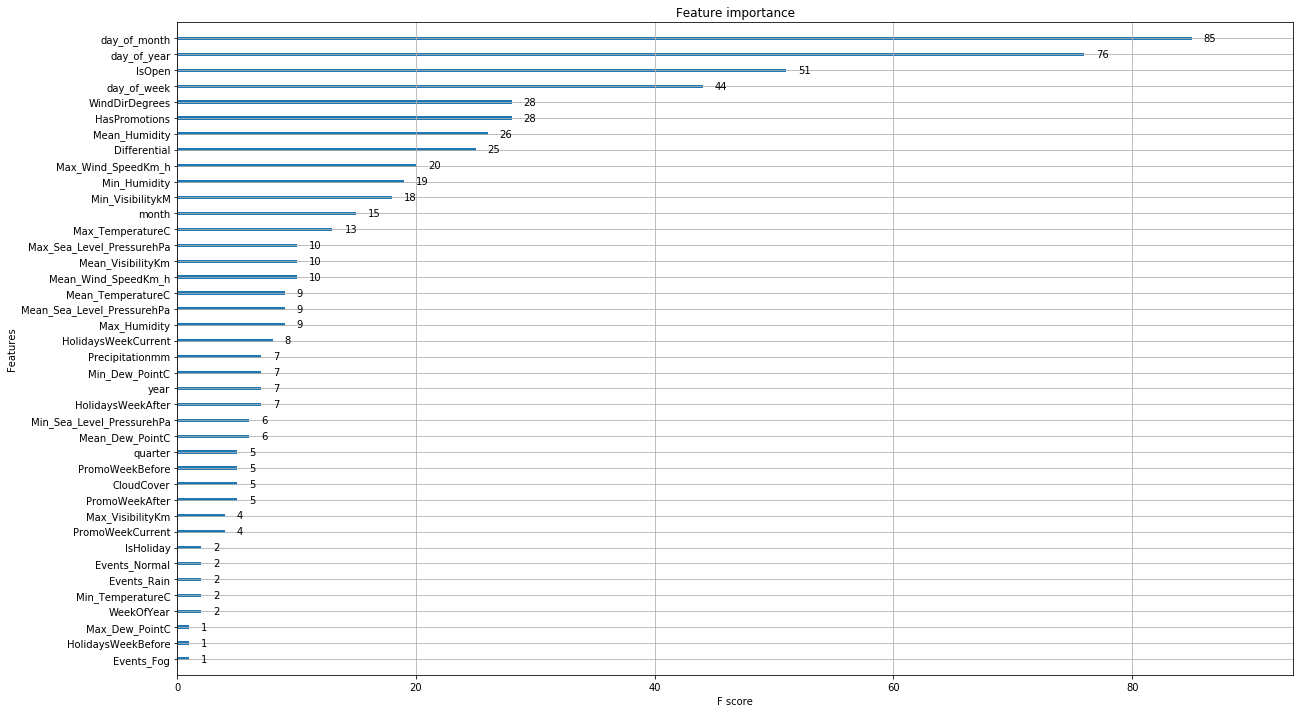

In [8]:
y_train = all_train[all_train.StoreID == 1000].NumberOfSales
x_train = all_train[all_train.StoreID == 1000].drop('NumberOfSales', axis = 1)

model = XGBRegressor(silent=False)
model.fit(x_train, y_train)

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plot_importance(model, ax=ax)

## Lanzi Error

### Fit model and make predictions

In [63]:
# train by month
def split_dataset_bymonth(test_year, test_months, train_set):
#     first_month_mask= all_train.month == test_months[0]
#     second_month_mask= all_train.month == test_months[1]
#     year_mask = all_train.year == test_year
#     test_mask = (first_month_mask | second_month_mask) & year_mask
    
    test_mask = (train_set.year == test_year) & train_set.month.isin(test_months)

    # define the train set
    train_dataset = train_set[~test_mask]
    x_train = train_dataset.drop('NumberOfSales', axis=1)
    y_train = train_dataset.NumberOfSales
    
    # define the test set
    test_dataset = train_set[test_mask]
    x_test = test_dataset.drop('NumberOfSales', axis=1)
    y_test = test_dataset.NumberOfSales
    
    return (x_train, y_train, x_test, y_test)

In [64]:
x_train, y_train, x_test, y_test =\
    split_dataset_bymonth(2017, [3, 4], all_train)

model = XGBRegressor(silent=False, n_jobs=4, max_depth=9, learning_rate=0.2)
# model = Lasso()
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [65]:
results = model.predict(x_test)
results

array([6104.999   , 7215.5684  , 7976.5913  , ..., 3656.566   ,
       2381.6516  ,   65.414246], dtype=float32)

In [66]:
x_test['Results'] = results
x_test['Actual'] = y_test

df_results = x_test[['StoreID', 'Results', 'Actual', 'month'] + r_regions]

predictions = defaultdict(dict)
for storeID, store in df_results.groupby('StoreID'):
    for month in store.month.unique():
        # store the monthly mean of the test set
        predictions[store.StoreID.unique()[0]][month] = {
            'predicted': np.sum(store.Results.sum()),
            'actual': np.sum(store.Actual.sum())
        }

In [54]:
# scores = {}
# predictions = defaultdict(dict)

# for storeid in all_train.StoreID.unique():
#     # define the model
#     model = XGBRegressor(silent=False)
    
#     # split the dataset
#     train = all_train[all_train.StoreID == storeid]
    
#     x_train, y_train, x_test, y_test =\
#     split_dataset_bymonth(2018, [1, 2], train)
    
#     # train the model with the training set
#     model.fit(x_train, y_train)
    
#     # scoring
#     scores[storeid] = r2_score(y_test, model.predict(x_test))
#     print('store {} -> {:.4f}'.format(storeid, scores[storeid]))
    
#     # predict the test set with the trained model
#     for month in x_test.month.unique():
#         # get daily predictions for each month in the test set
#         month_prediction = model.predict(x_test[x_test.month == month])
#         month_actual = y_test.loc[x_test[x_test.month == month].index].values
        
#         # store the monthly mean of the test set
#         predictions[storeid][month] = {
#             'predicted': np.sum(month_prediction),
#             'actual': np.sum(month_actual)
#         }

### Compute Lanzi error

In [67]:
# set of regions
R = sorted(all_train_orig.Region.unique().astype(int))
# set of predicted months
months = [key for key, value in predictions[1000].items()]
# set of stores by region
dict_store_byRegion = all_train_orig[['Region', 'StoreID']].drop_duplicates()\
.set_index('StoreID').groupby('Region').groups

# region_error inputs:
#
# int region = a number from 0 to 11
# dict predictions = {
#     int storeID: {
#         int month: {
#             str 'predicted': float,
#             str 'actual': float
#         }
#         ...
#     }
#     ...
# }
def region_error(region, predictions):    
    num = 0
    den = 0
    for store in dict_store_byRegion[str(region)]:
        for month in months:
            predicted = predictions[store][month]['predicted']
            actual = predictions[store][month]['actual']
            
            num += abs(actual - predicted)
            den += actual
    
    return num/den
    
# total_error input:
#
# region_errors = [0.3, 0.5, ... ]
def total_error(region_errors):
    return sum(region_errors)/len(region_errors)

def lanzi_error(predictions):
    region_errors = []
    for r in R:
        region_errors.append(region_error(r, predictions))
    
    return total_error(region_errors)

In [68]:
print('Lanzi error: {}'.format(lanzi_error(predictions)))

Lanzi error: 0.03352515271388008


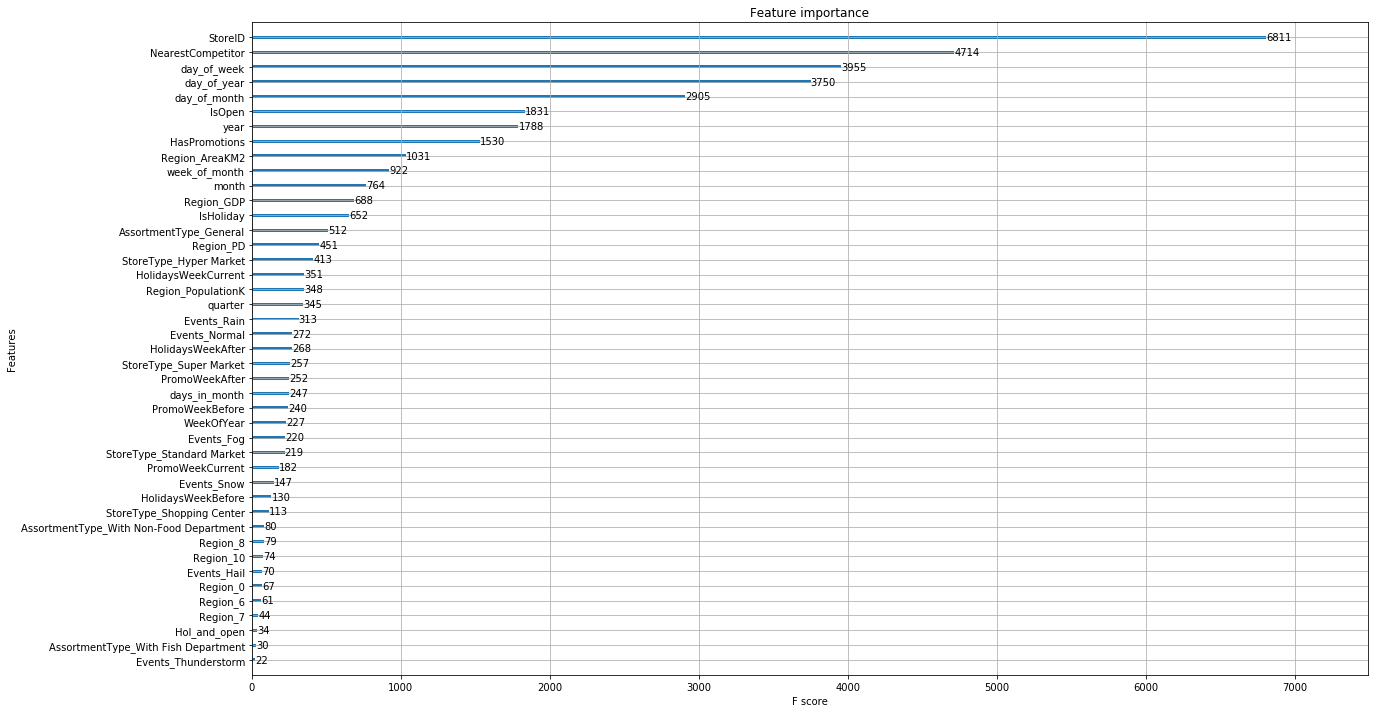

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(20, 12))
plot_importance(model, ax=ax)

## Score submit

In [11]:
# Load test set to predict
with open(data_path_out + 'test_pp.obj', 'rb') as file:
    all_test = pickle.load(file)
    
all_test = all_test.drop(labels=['Region', 'Date'], axis=1)

# HACK: remove differential
all_train = all_train.drop(labels=['Differential'], axis=1)

print(all_test.shape)
all_train.head()

(45689, 85)


,StoreID,IsHoliday,IsOpen,HasPromotions,NearestCompetitor,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,Max_Dew_PointC,Max_Humidity,Max_Sea_Level_PressurehPa,Max_TemperatureC,Max_VisibilityKm,Max_Wind_SpeedKm_h,Mean_Dew_PointC,Mean_Humidity,Mean_Sea_Level_PressurehPa,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees,Hol_and_open,Region_PD,week_of_month,year,quarter,month,day_of_month,day_of_week,day_of_year,WeekOfYear,days_in_month,Region_0,Region_1,Region_10,Region_2,Region_3,Region_4,Region_5,Region_7,Region_9,Region_6,Region_8,AssortmentType_General,AssortmentType_With Non-Food Department,AssortmentType_With Fish Department,StoreType_Hyper Market,StoreType_Standard Market,StoreType_Super Market,StoreType_Shopping Center,Events_Fog,Events_Fog-Rain,Events_Fog-Rain-Hail,Events_Fog-Rain-Hail-Thunderstorm,Events_Fog-Rain-Snow,Events_Fog-Rain-Snow-Hail,Events_Fog-Rain-Thunderstorm,Events_Fog-Snow,Events_Fog-Snow-Hail,Events_Fog-Thunderstorm,Events_Normal,Events_Rain,Events_Rain-Hail,Events_Rain-Hail-Thunderstorm,Events_Rain-Snow,Events_Rain-Snow-Hail,Events_Rain-Snow-Hail-Thunderstorm,Events_Rain-Snow-Thunderstorm,Events_Rain-Thunderstorm,Events_Snow,Events_Snow-Hail,Events_Thunderstorm,HolidaysWeekBefore,HolidaysWeekCurrent,HolidaysWeekAfter,PromoWeekBefore,PromoWeekCurrent,PromoWeekAfter,NumberOfSales
0,1000,False,True,False,326,9643,17130,2770,8.0,1,100,1032,2,19.0,21,-1,82,1030,1,11.0,16,-2,70,1029,1,6.0,0.0,23,False,0.287255,0,2016,1,3,1,1,61,9,31,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,5,5676
1,1000,False,True,False,326,9643,17130,2770,8.0,0,87,1030,5,23.0,16,-1,73,1027,3,13.0,10,-2,58,1025,1,10.0,0.0,56,False,0.287255,0,2016,1,3,2,2,62,9,31,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5,8111
2,1000,False,True,False,326,9643,17130,2770,8.0,0,81,1026,4,31.0,23,-1,71,1024,3,11.0,10,-3,55,1023,2,8.0,0.0,22,False,0.287255,0,2016,1,3,4,4,64,9,31,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,8300
3,1000,False,True,False,326,9643,17130,2770,6.0,-3,80,1027,8,31.0,19,-4,56,1024,3,15.0,10,-6,25,1022,-1,10.0,0.0,108,False,0.287255,0,2016,1,3,5,5,65,9,31,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,7154
4,1000,False,False,False,326,9643,17130,2770,6.0,0,93,1025,7,31.0,16,-3,75,1023,1,12.0,5,-6,48,1022,-5,5.0,0.0,46,False,0.287255,0,2016,1,3,6,6,66,9,31,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0


In [12]:
# Create submit dataframe
data_path_in = 'Data/input/'
data_type = {
    'StoreID': 'uint16',
    'Month': 'uint8',
    'NumberOfSales': 'uint32'
}

df_submission = pd.read_csv(data_path_in+'sample_submission.csv', dtype=data_type)
df_submission.head()

,StoreID,Month,NumberOfSales
0,1000,3,0
1,1000,4,0
2,1001,3,0
3,1001,4,0
4,1002,3,0


In [23]:
# train and test set prediction
print_score = False
month_list = df_submission.Month.unique()

for storeid in all_test.StoreID.unique():
    # split dataset
    train_current_store = all_train[all_train.StoreID == storeid]
    test_current_store = all_test[all_test.StoreID == storeid]
    
    x_train = train_current_store.drop('NumberOfSales', axis=1)
    y_train = train_current_store.NumberOfSales
    x_test = all_test
    
    # train the model with the training set
    model = XGBRegressor(silent=False)
    model.fit(x_train, y_train)
    print(storeid)
    # Score
    if print_score:
        kfold = KFold(n_splits=5, shuffle=True, random_state=7)
        cv_score = cross_val_score(model, x_train, y_train, scoring='r2', cv=kfold)
        print('Cross-validation for {} -> score: {:.4f} with +/- {:.4f}'\
              .format(storeid, cv_score.mean(), cv_score.std()))
    
    # predict the test set with the trained model
    for month in month_list:
        mask = (df_submission.StoreID == storeid) & (df_submission.Month == month)
        month_prediction = model.predict(x_test[x_test.month == month])
        df_submission.at[mask, 'NumberOfSales'] = np.sum(month_prediction)

1000
1001


In [24]:
# write submission csv
df_submission.to_csv(data_path_out+'submission.csv', index=False)